In [1]:
import os
import pathlib
from tqdm import tqdm
import pandas as pd
import random
import cv2 
import re
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as torchvision_T 

In [2]:
background_path = '/mnt/d/ws/data/diploma/backgrounds_images_google/downloads/'
document_paths = [r"D:\ws\data\diploma\datasets\Tobacco3482",]


output_path = '/mnt/d/ws/data/diploma/datasets/my_ds_segmentation/'

In [3]:
document_paths = [re.sub(r'D:\\ws\\data\\','/mnt/d/ws/data/',v) for v in document_paths]

In [4]:
document_paths =[v.replace('\\','/') for v in document_paths]

In [5]:
bag_path = pathlib.Path(background_path)


In [6]:
bag_paths = list(bag_path.rglob('*.jpg'))
print(len(bag_paths))


875


In [7]:
doc_path_files = []
for doc_path in document_paths:
    _pth = pathlib.Path(doc_path)
    for glob_search in ('*.jpg','*.jpeg','*.png'):
        doc_path_files+=list(_pth.rglob(glob_search))

In [8]:
len(doc_path_files)

3482

In [9]:
doc_paths = random.choices(doc_path_files,k=len(bag_paths))
print(len(doc_paths))

875


In [10]:
def generate_transformation_coordinates(height:int,width:int):
    logic_x = (False,True,True,False)
    logic_y = (False,False,True,True)
    x_rand_border = width//2
    y_rand_border = height//2
    res_coords = []
    for xa,ya in zip(logic_x,logic_y):
        coord = []
        coord.append(
            ((width-x_rand_border) if xa else 0)+ random.randint(0,x_rand_border)
        )
        coord.append(
            ((height-y_rand_border) if ya else 0)+ random.randint(0,y_rand_border)
        )
        res_coords.append(coord)
    return res_coords

In [11]:
dest_size_h = 512
dest_size_w = 512

In [12]:
def calculate_resize(h_doc,w_doc,h_bag,w_bag):
    
    h_res = h_bag if h_bag>=h_doc else h_doc
    w_res = w_bag if w_bag>=w_doc else w_doc
    return h_res,w_res

In [13]:
def prespective_transform_mask(image_src):
    image =image_src.copy()
    height, width = image.shape[:2]
    x1, y1 = 0, 0 
    x2, y2 = width, 0 
    x3, y3 = width, height 
    x4, y4 = 0, height 
    points_src = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    points_dst = np.float32(generate_transformation_coordinates(height=height,width=width))
    matrix = cv2.getPerspectiveTransform(points_src, points_dst)
    transformed = cv2.warpPerspective(image, matrix, (width, height)) 
    mask = transformed.copy()
    mask[mask!=0]=1
    return transformed,mask

In [14]:
df_data = []
i = 0
for doc_p,bag_p in tqdm(zip(doc_paths,bag_paths)):
    
    doc_im = cv2.imread(str(doc_p))
    bag_im = cv2.imread(str(bag_p))
    
    doc_im_gray = cv2.cvtColor(doc_im,cv2.COLOR_BGR2GRAY)
    bag_im_gray = cv2.cvtColor(bag_im,cv2.COLOR_BGR2GRAY)
    
    res_h,res_w = calculate_resize(*doc_im.shape[:2],*bag_im.shape[:2])
    bag_im_norm = cv2.resize(bag_im,[dest_size_h,dest_size_w])
    doc_im_norm = cv2.resize(doc_im,[dest_size_h,dest_size_w])
    
    image = doc_im_norm.copy()
    height, width = image.shape[:2]
    x1, y1 = 0, 0    # Lewy górny narożnik
    x2, y2 = width, 0   # Prawy górny narożnik
    x3, y3 = width, height  # Prawy dolny narożnik
    x4, y4 = 0, height   # Lewy dolny narożnik
    points_src = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

    cords = generate_transformation_coordinates(height=height,width=width)
    points_dst = np.float32(cords)

    matrix = cv2.getPerspectiveTransform(points_src, points_dst)
    transformed = cv2.warpPerspective(image, matrix, (width, height))
    transformed_mask = cv2.warpPerspective(np.ones_like(image), matrix, (width, height))
    res_im = np.where(transformed_mask.flatten()==1,transformed.flatten(),bag_im_norm.flatten()).reshape(transformed.shape)
    res_im_gray =cv2.cvtColor(res_im,cv2.COLOR_BGR2GRAY)
    i+=1
    export_name = f'./export_data/{i}.png'
    cv2.imwrite(export_name,res_im_gray)
    df_data.append({
        'cords':cords,
        'doc_p':doc_p,
        'bag_p':bag_p,
        'export_name':export_name
    })


875it [01:24, 10.41it/s]


In [16]:
df = pd.DataFrame(df_data)

,cords,doc_p,bag_p,export_name
0,"[[138, 6], [342, 220], [448, 441], [189, 375]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/1.png
1,"[[252, 36], [371, 49], [374, 429], [250, 474]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/2.png
2,"[[222, 61], [262, 73], [477, 307], [237, 301]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/3.png
3,"[[183, 117], [495, 227], [377, 452], [99, 340]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/4.png
4,"[[100, 13], [507, 124], [329, 456], [165, 330]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/5.png
...,...,...,...,...
870,"[[241, 169], [466, 166], [364, 277], [139, 434]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/871.png
871,"[[106, 174], [389, 166], [373, 382], [71, 371]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/872.png
872,"[[204, 17], [262, 230], [465, 501], [42, 412]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/873.png
873,"[[226, 185], [264, 14], [394, 350], [204, 457]]",/mnt/d/ws/data/diploma/datasets/Tobacco3482/To...,/mnt/d/ws/data/diploma/backgrounds_images_goog...,./export_data/874.png


In [27]:
df.to_pickle('annot_data.pkl')

In [18]:
df.iloc[474]

cords              [[5, 18], [342, 222], [451, 285], [209, 323]]
doc_p          /mnt/d/ws/data/diploma/datasets/Tobacco3482/To...
bag_p          /mnt/d/ws/data/diploma/backgrounds_images_goog...
export_name                                ./export_data/475.png
Name: 474, dtype: object

In [24]:
im = cv2.imread('./export_data/475.png')

In [25]:
c = [[125,0,0],
    [255,0,0],
     [0,255,0],
     [0,0,255]
    ]
i=0
for point in [[5, 18], [342, 222], [451, 285], [209, 323]]:
    cv2.circle(im,point,5,c[i],-1)
    i+=1

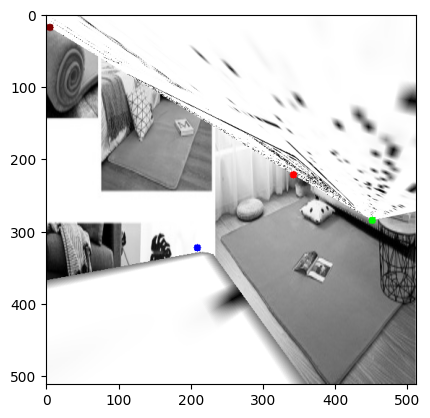

In [26]:
plt.imshow(im)

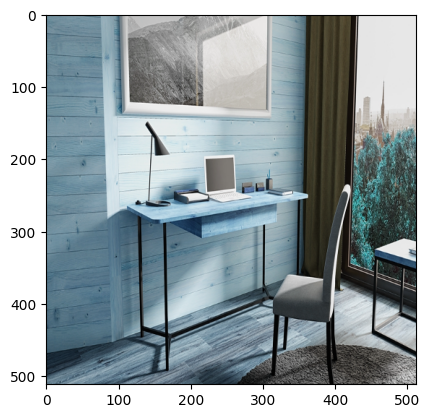

In [37]:

# Współrzędne narożników kartki na oryginalnym obrazie

image = doc_im_norm.copy()
# Wczytanie obrazu
width = 512
height = 512
# image =image_src.copy()
# mask = np.all(image==np.array([0,0,0],axis=-1))
# # Wymiary obrazu
# height, width = image.shape[:2]
# Przykładowe wartości - musisz je dostosować do swojego obrazu
x1, y1 = 0, 0    # Lewy górny narożnik
x2, y2 = width, 0   # Prawy górny narożnik
x3, y3 = width, height  # Prawy dolny narożnik
x4, y4 = 0, height   # Lewy dolny narożnik
# Punkty w oryginalnym obrazie
# Wybierz cztery punkty w taki sposób, aby reprezentowały prostokąt
# na przykład narożniki książki lub kartki papieru
points_src = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

# Punkty docelowe, gdzie chcemy umieścić punkty źródłowe w wynikowym obrazie
cords = generate_transformation_coordinates(height=height,width=width)
# Zazwyczaj wybiera się narożniki (lewy górny, prawy górny, prawy dolny, lewy dolny)
points_dst = np.float32(cords)

# Obliczenie macierzy transformacji
matrix = cv2.getPerspectiveTransform(points_src, points_dst)

# Przeprowadzenie transformacji perspektywicznej
transformed = cv2.warpPerspective(np.ones_like(image), matrix, (width, height))

# points_dst = np.float32(generate_transformation_coordinates(height=height,width=width))

# # Obliczenie macierzy transformacji
# matrix = cv2.getPerspectiveTransform(points_src, points_dst)

# # Przeprowadzenie transformacji perspektywicznej
# transformed = cv2.warpPerspective(transformed, matrix, (width, height))

# Wyświetlenie obrazu
plt.imshow( image)

# [60:200,250:400]

In [ ]:
DataFrame